# Stock Market Analysis using CNN-LSTM model
This project is about analysis of Stock Market and providing suggestions and predictions to the stockholders. For this, we used CNN-LSTM approach to create a blank model, then use it to train on stock market data. Further implementation is discussed below...

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Preprocessing and Analysis

In [2]:
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

First we'd read the CSV file and then drop the null columns. Then we'd check the columns (some not all)

In [3]:
#1DP18XAREYFRWP4I
import requests
import csv
from tqdm import tqdm
key = "1DP18XAREYFRWP4I"

def request_stock_price_list(symbol, size, token):
    q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, size, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 7))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount", "split cf"]
    df['date'] = date
    return df

In [4]:
cv1 = request_stock_price_list('IBM', 'full', key)
print(cv1.head)
cv1.to_csv('data.csv')

Retrieving stock price data from Alpha Vantage (This may take a while)...
Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 5556/5556 [01:47<00:00, 51.65it/s]


<bound method NDFrame.head of         open     high     low   close adjusted close    volume  \
0     118.62   119.61  117.53   118.5          118.5   8918702   
1      115.0  116.335  114.56  115.81         115.81   3322012   
2     116.16   117.27  116.08  116.73         116.73   3220802   
3     116.79   117.94  116.04  116.79         116.79   4914995   
4      116.0   118.81  115.19  116.47         116.47   6417218   
...      ...      ...     ...     ...            ...       ...   
5551   92.75    92.94   90.19   90.25  52.2266076272  13737600   
5552   94.44    94.44    90.0   91.56  52.9846891341  16697600   
5553   95.87    95.94    93.5   94.37  54.6108029006  10369100   
5554   96.75    96.81   93.69   94.81  54.8654256968  11105400   
5555    98.5    98.81   96.37   96.75  55.9880807527   9551800   

     dividend amount split cf        date  
0             0.0000      1.0  2021-11-29  
1             0.0000      1.0  2021-11-26  
2             0.0000      1.0  2021-11-24  
3

In [5]:
# For data preprocessing and analysis part
data = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/abe.us.txt')
#data = pd.read_csv('../input/nifty50-stock-market-data/COALINDIA.csv')
#data = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ABCO.csv')
#data = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data.dropna(inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 0 to 3189
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3190 non-null   object 
 1   Open     3190 non-null   float64
 2   High     3190 non-null   float64
 3   Low      3190 non-null   float64
 4   Close    3190 non-null   float64
 5   Volume   3190 non-null   int64  
 6   OpenInt  3190 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 199.4+ KB


In [7]:
data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,3190.000000,3190.000000,3190.000000,3190.000000,3190.000000,3190.0
mean,11.599416,11.712848,11.484610,11.605599,28444.870846,0.0
std,2.350376,2.365621,2.327065,2.341989,37525.175821,0.0
min,5.860300,5.905000,5.834700,5.841100,106.000000,0.0
25%,10.534000,10.655000,10.413750,10.554000,8147.750000,0.0
50%,11.981000,12.067000,11.899000,11.988500,17741.500000,0.0
75%,13.271000,13.386750,13.189000,13.295750,36167.250000,0.0
max,18.130000,19.151000,17.842000,17.925000,634041.000000,0.0


In [8]:
data.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [9]:
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,6.4987,6.6009,6.4668,6.5753,55766,0
1,2005-02-28,6.6072,6.7669,6.5944,6.6263,49343,0
2,2005-03-01,6.6391,6.6773,6.6072,6.6072,31643,0
3,2005-03-02,6.5753,6.6072,6.5434,6.5816,27101,0
4,2005-03-03,6.5753,6.6135,6.5562,6.5944,17387,0


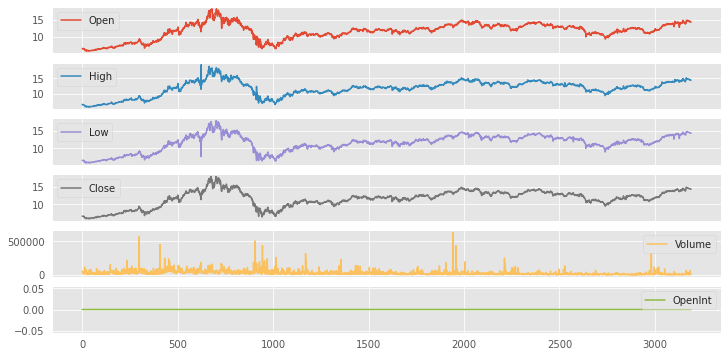

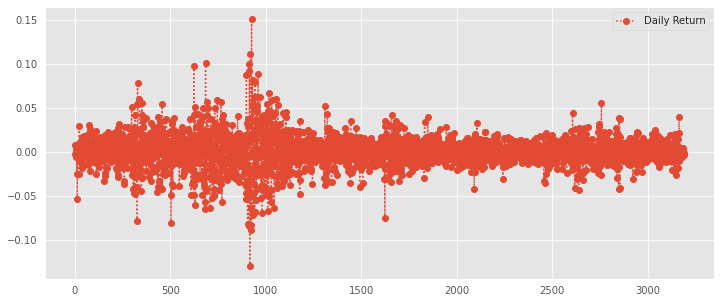

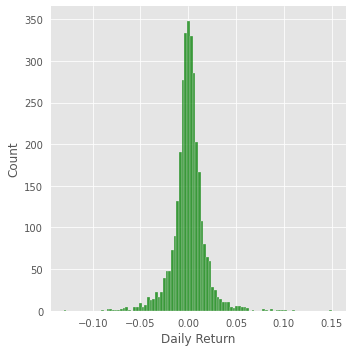

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

Date               0
Open               0
High               0
Low                0
Close              0
Volume             0
OpenInt            0
MA for 10 days     0
MA for 50 days     0
MA for 100 days    0
Daily Return       0
dtype: int64

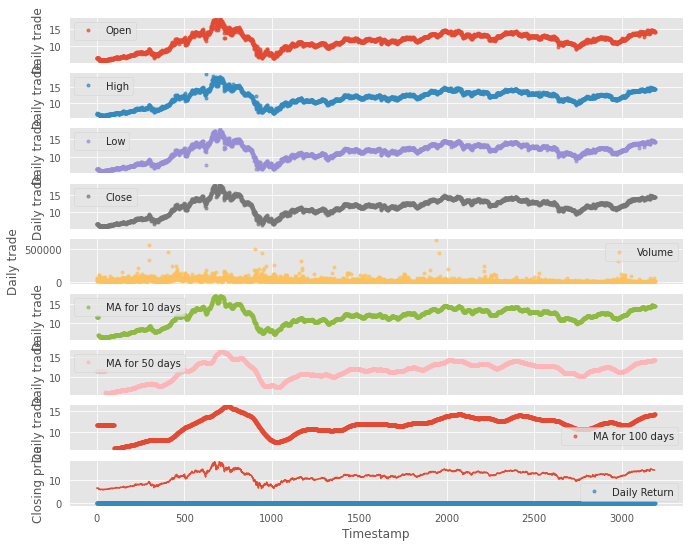

In [10]:
data.plot(legend=True,subplots=True, figsize = (12, 6))
plt.show()
#data['Close'].plot(legend=True, figsize = (12, 6))
#plt.show()
#data['Volume'].plot(legend=True,figsize=(12,7))
#plt.show()

data.shape
data.size
data.describe(include='all').T
data.dtypes
data.nunique()
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
# plot the daily return percentage
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')
plt.show()

sns.displot(data['Daily Return'].dropna(),bins=100,color='green')
plt.show()

date=pd.DataFrame(data['Date'])
closing_df1 = pd.DataFrame(data['Close'])
close1  = closing_df1.rename(columns={"Close": "data_close"})
close2=pd.concat([date,close1],axis=1)
close2.head()

data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

data.nunique()

data.sort_index(axis=1,ascending=True)

cols_plot = ['Open', 'High', 'Low','Close','Volume','MA for 10 days','MA for 50 days','MA for 100 days','Daily Return']
axes = data[cols_plot].plot(marker='.', alpha=0.7, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

data.isnull().sum()

After that, we'll visualize the data for understanding, this is shown below...

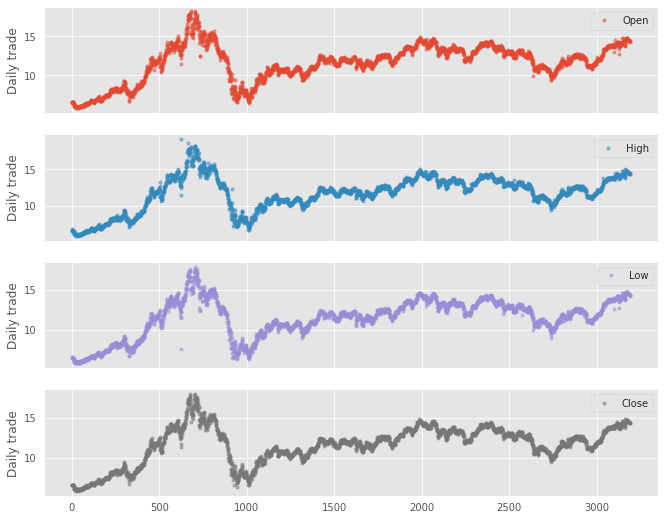

In [11]:
cols_plot = ['Open', 'High', 'Low','Close']
axes = data[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

Then we'd print the data after making changes and dropping null data

            Date     Open     High      Low    Close  Volume  OpenInt  \
0     2005-02-25   6.4987   6.6009   6.4668   6.5753   55766        0   
1     2005-02-28   6.6072   6.7669   6.5944   6.6263   49343        0   
2     2005-03-01   6.6391   6.6773   6.6072   6.6072   31643        0   
3     2005-03-02   6.5753   6.6072   6.5434   6.5816   27101        0   
4     2005-03-03   6.5753   6.6135   6.5562   6.5944   17387        0   
...          ...      ...      ...      ...      ...     ...      ...   
3185  2017-11-06  14.3998  14.4802  14.3900  14.4400   62423        0   
3186  2017-11-07  14.4400  14.4400  14.4000  14.4000    6722        0   
3187  2017-11-08  14.3400  14.4352  14.3400  14.3781    6304        0   
3188  2017-11-09  14.3300  14.3737  14.2800  14.3200   18761        0   
3189  2017-11-10  14.2500  14.3000  14.2400  14.3000   10658        0   

      MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0           11.60878       11.625272        11.649354

,count,mean,std,min,25%,50%,75%,max
Open,3190.0,11.599416,2.350376,5.860300,10.534000,11.981000,13.271000,18.130000
High,3190.0,11.712848,2.365621,5.905000,10.655000,12.067000,13.386750,19.151000
Low,3190.0,11.484610,2.327065,5.834700,10.413750,11.899000,13.189000,17.842000
Close,3190.0,11.605599,2.341989,5.841100,10.554000,11.988500,13.295750,17.925000
Volume,3190.0,28444.870846,37525.175821,106.000000,8147.750000,17741.500000,36167.250000,634041.000000
OpenInt,3190.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MA for 10 days,3190.0,11.608780,2.321162,5.963080,10.577125,11.962700,13.297200,17.329400
MA for 50 days,3190.0,11.625272,2.231059,6.037646,10.591696,11.933450,13.269480,16.618460
MA for 100 days,3190.0,11.649354,2.113346,6.221377,10.632551,11.876775,13.200810,16.042560
Daily Return,3190.0,0.000388,0.017010,-0.130345,-0.006439,0.000484,0.007807,0.150503


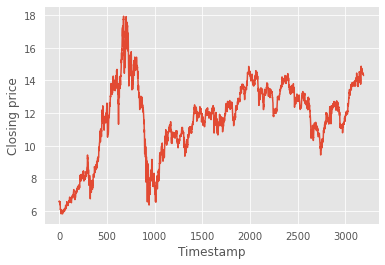

In [12]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

In [13]:
X = data.drop(['Date', 'Close'], axis=1)
Y = data['Close']

X.shape,Y.shape

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

lreg = LinearRegression()
sfs1 = sfs(lreg, k_features=2, forward=False, verbose=2, scoring='neg_mean_squared_error')

sfs1 = sfs1.fit(X, Y)

feat_names = list(sfs1.k_feature_names_)
print(feat_names)

# creating a new dataframe using the above variables and adding the target variable
new_data = data[feat_names]
new_data['Close'] = data['Close']

# first five rows of the new data
new_data.head()

new_data.shape, data.shape

df = new_data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished

[2021-11-30 00:29:45] Features: 8/2 -- score: -0.01130510673631423[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished

[2021-11-30 00:29:45] Features: 7/2 -- score: -0.011114316874792215[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s finished

[2021-11-30 00:29:45] Features: 6/2 -- score: -0.011080371541763374[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: D

['High', 'Low']


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished

[2021-11-30 00:29:46] Features: 5/2 -- score: -0.011080371541730121[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished

[2021-11-30 00:29:46] Features: 4/2 -- score: -0.011086733169734618[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2021-11-30 00:29:46] Features: 3/2 -- score: -0.011860213917250834[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2021-11-30 00:29:46] Features: 

The data has been analysed but it must be converted into data of shape [100,1] to make it easier for CNN to train on... Else it won't select necessary features and the model will fail

In [14]:
from sklearn.model_selection import train_test_split

X = []
Y = []
window_size=100
for i in range(1 , len(df) - window_size -1 , 1):
    first = df.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df.iloc[i + j, 2] - first) / first)
    temp2.append((df.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2470
618


## Training part

This part has 2 subparts: CNN and LSTM

For CNN, the layers are created with sizes 64,128,64. In every layer, TimeDistributed function is added to track the features with respect to time. In between them, Pooling layers are added.

After that, it's passed to Bi-LSTM layers

In [15]:
# For creating model and training
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

model = tf.keras.Sequential()

# Creating the Neural Network model here...
model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu', input_shape=(None, 100, 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=1, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=40,batch_size=40, verbose=1, shuffle =True)

2021-11-30 00:29:56.108575: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-11-30 00:30:00.219156: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-30 00:30:00.222354: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-30 00:30:00.260717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 00:30:00.261351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-11-30 00:30:00.261400: I tensorflow/stream_executor/platform/def

Epoch 1/40


2021-11-30 00:30:08.299035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-11-30 00:30:09.125495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-11-30 00:30:09.150856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


62/62 [==============================] - 15s 44ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0790 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0365
Epoch 2/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0366 - val_loss: 0.0022 - val_mse: 0.0022 - val_mae: 0.0337
Epoch 3/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0327 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0320
Epoch 4/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0328 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0301
Epoch 5/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0326 - val_loss: 0.0024 - val_mse: 0.0024 - val_mae: 0.0364
Epoch 6/40
62/62 [==============================] - 1s 10ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0328 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0302
Epoch 7/40
62/62 [==============

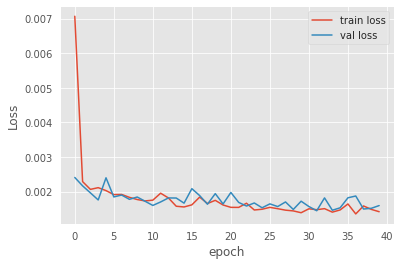

In [16]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

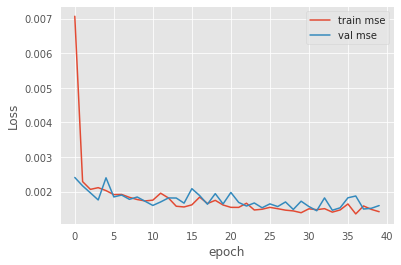

In [17]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

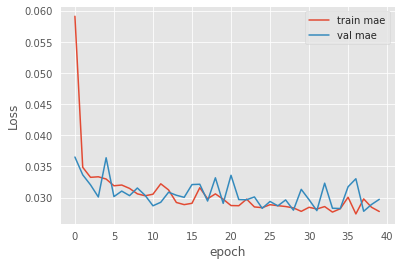

In [18]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 100, 64)        128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 50, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 50, 128)        8320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 25, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 25, 64)         8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 12, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 768)            0

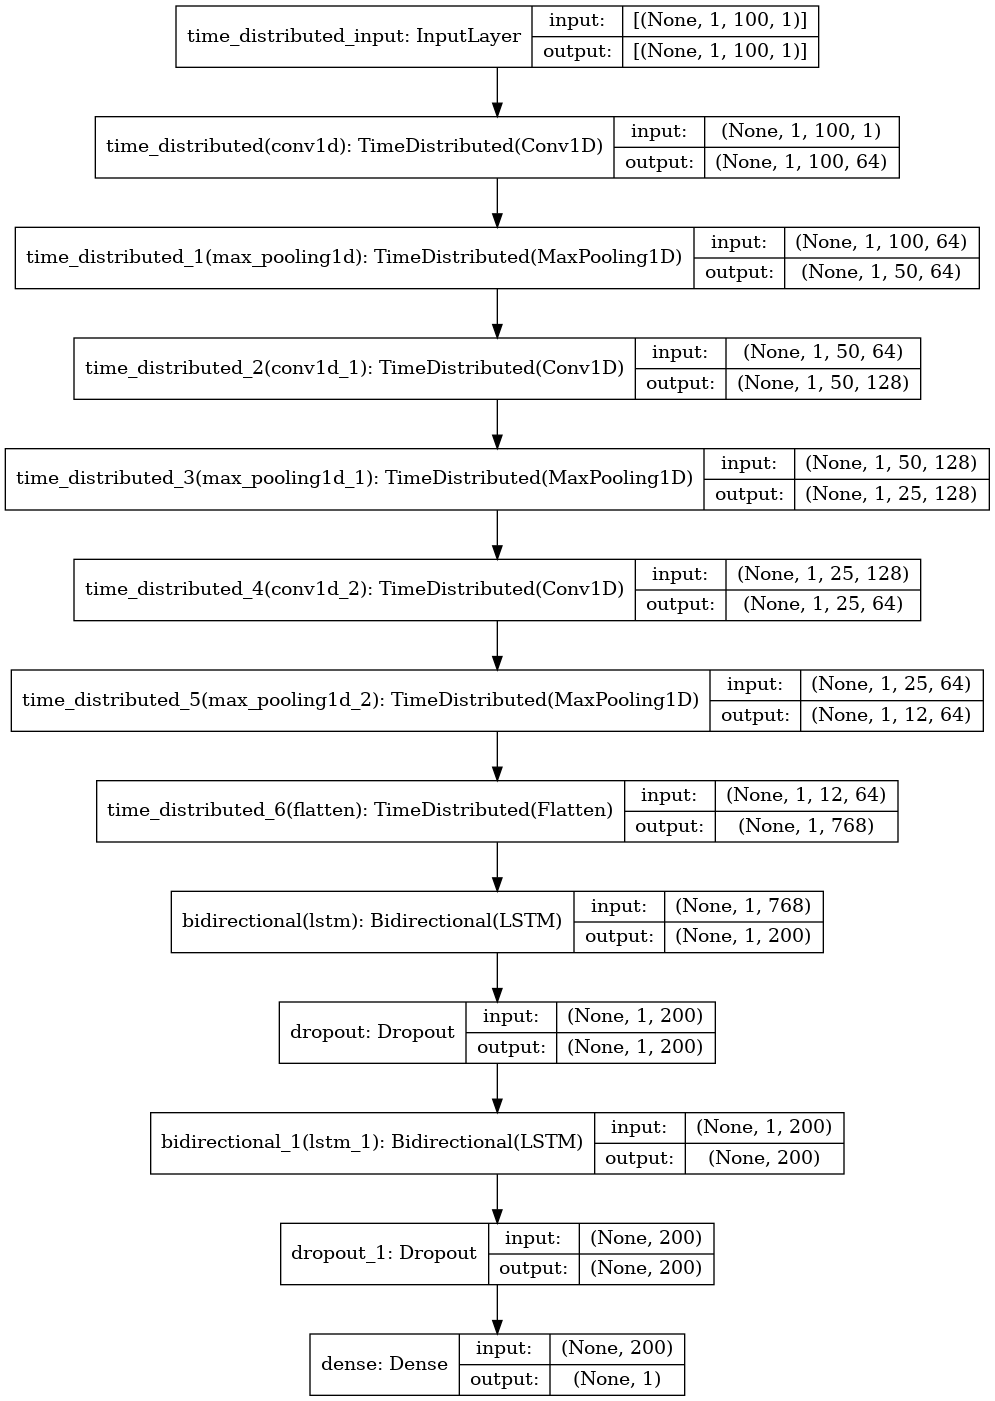

In [19]:
# After the model has been constructed, we need to train
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [20]:
model.evaluate(test_X, test_Y)

20/20 [==============================] - 0s 5ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0297   


[0.001593530410900712, 0.001593530410900712, 0.029720278456807137]

In [21]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(test_X, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(test_X, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.934336
R2 Score: 0.934336
Max Error: 0.184483


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


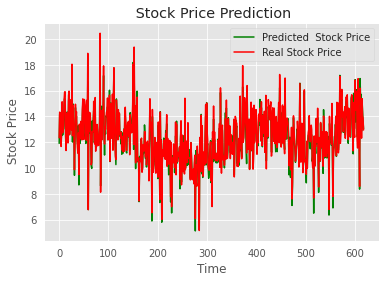

In [22]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

## Testing part

In this part, the model is saved and loaded back again. Then, it's made to train again but with different data to check it's loss and prediction

In [23]:
# First we need to save a model
model.save("model.h5")

In [24]:
# Load model
new_model = tf.keras.models.load_model("./model.h5")

In [25]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 100, 64)        128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 50, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 50, 128)        8320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 25, 128)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 25, 64)         8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 12, 64)         0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 768)            0

In [26]:
# For data preprocessing and analysis part
#data2 = pd.read_csv('../input/price-volume-data-for-all-us-stocks-etfs/Stocks/aaoi.us.txt')
#data2 = pd.read_csv('../input/nifty50-stock-market-data/SBIN.csv')
#data2 = pd.read_csv('../input/stock-market-data/stock_market_data/nasdaq/csv/ACTG.csv')
data2 = pd.read_csv('./data.csv')
# Any CSV or TXT file can be added here....
data2.dropna(inplace=True)
data2.head()

data2.reset_index(drop=True, inplace=True)
data2.fillna(data.mean(), inplace=True)
data2.head()
df2 = data2.drop('date', axis=1)

print(df2)

X = []
Y = []
window_size=100
for i in range(1 , len(df2) - window_size -1 , 1):
    first = df2.iloc[i,4]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((df2.iloc[i + j, 4] - first) / first)
    # for j in range(week):
    temp2.append((df2.iloc[i + window_size, 4] - first) / first)
    # X.append(np.array(stock.iloc[i:i+window_size,4]).reshape(50,1))
    # Y.append(np.array(stock.iloc[i+window_size,4]).reshape(1,1))
    # print(stock2.iloc[i:i+window_size,4])
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

      Unnamed: 0    open     high     low   close  adjusted close    volume  \
0              0  118.62  119.610  117.53  118.50      118.500000   8918702   
1              1  115.00  116.335  114.56  115.81      115.810000   3322012   
2              2  116.16  117.270  116.08  116.73      116.730000   3220802   
3              3  116.79  117.940  116.04  116.79      116.790000   4914995   
4              4  116.00  118.810  115.19  116.47      116.470000   6417218   
...          ...     ...      ...     ...     ...             ...       ...   
5551        5551   92.75   92.940   90.19   90.25       52.226608  13737600   
5552        5552   94.44   94.440   90.00   91.56       52.984689  16697600   
5553        5553   95.87   95.940   93.50   94.37       54.610803  10369100   
5554        5554   96.75   96.810   93.69   94.81       54.865426  11105400   
5555        5555   98.50   98.810   96.37   96.75       55.988081   9551800   

      dividend amount  split cf  
0                

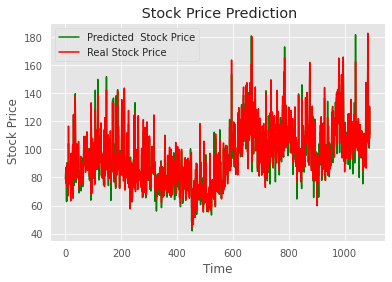

In [27]:
predicted  = model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data2.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# EDA

In [56]:
dataX = pd.read_csv('./data.csv')
dataY = pd.read_csv('./data.csv')
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556 entries, 0 to 5555
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       5556 non-null   int64  
 1   open             5556 non-null   float64
 2   high             5556 non-null   float64
 3   low              5556 non-null   float64
 4   close            5556 non-null   float64
 5   adjusted close   5556 non-null   float64
 6   volume           5556 non-null   int64  
 7   dividend amount  5556 non-null   float64
 8   split cf         5556 non-null   float64
 9   date             5556 non-null   object 
dtypes: float64(7), int64(2), object(1)
memory usage: 434.2+ KB


In [57]:
dataX.head()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,118.62,119.610,117.53,118.50,118.50,8918702,0.0,1.0,2021-11-29
1,1,115.00,116.335,114.56,115.81,115.81,3322012,0.0,1.0,2021-11-26
2,2,116.16,117.270,116.08,116.73,116.73,3220802,0.0,1.0,2021-11-24
3,3,116.79,117.940,116.04,116.79,116.79,4914995,0.0,1.0,2021-11-23
4,4,116.00,118.810,115.19,116.47,116.47,6417218,0.0,1.0,2021-11-22


In [58]:
start_date = '2020-01-01'
end_date = '2021-11-29'

start = '2018-01-01'
end = '2020-01-01'

fill = (dataX['date']>=start_date) & (dataX['date']<=end_date)
dataX = dataX.loc[fill]
dataX


,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,0,118.62,119.610,117.53,118.50,118.500000,8918702,0.0,1.0,2021-11-29
1,1,115.00,116.335,114.56,115.81,115.810000,3322012,0.0,1.0,2021-11-26
2,2,116.16,117.270,116.08,116.73,116.730000,3220802,0.0,1.0,2021-11-24
3,3,116.79,117.940,116.04,116.79,116.790000,4914995,0.0,1.0,2021-11-23
4,4,116.00,118.810,115.19,116.47,116.470000,6417218,0.0,1.0,2021-11-22
...,...,...,...,...,...,...,...,...,...,...
477,477,134.51,135.860,133.92,135.31,117.011071,4345952,0.0,1.0,2020-01-08
478,478,133.69,134.960,133.40,134.19,116.042537,3267592,0.0,1.0,2020-01-07
479,479,133.42,134.240,133.20,134.10,115.964708,2421128,0.0,1.0,2020-01-06
480,480,133.57,134.860,133.56,134.34,116.172251,2373470,0.0,1.0,2020-01-03


In [59]:
fill2 = (dataY['date']>=start) & (dataY['date']<=end)
dataY = dataY.loc[fill2]
dataY

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
482,482,132.53,134.12,132.40,134.04,115.912822,3777504,0.0,1.0,2019-12-31
483,483,135.20,135.30,132.50,132.81,114.849164,4118929,0.0,1.0,2019-12-30
484,484,135.00,135.75,134.87,135.27,116.976481,2752185,0.0,1.0,2019-12-27
485,485,134.98,135.31,134.65,134.91,116.665166,2129654,0.0,1.0,2019-12-26
486,486,135.61,135.62,134.61,134.98,116.725700,1202087,0.0,1.0,2019-12-24
...,...,...,...,...,...,...,...,...,...,...
980,980,162.66,163.91,161.70,163.47,129.027615,5101023,0.0,1.0,2018-01-08
981,981,162.44,162.90,161.10,162.49,128.254097,5162075,0.0,1.0,2018-01-05
982,982,159.65,162.32,159.37,161.70,127.630546,7363843,0.0,1.0,2018-01-04
983,983,157.34,159.81,156.33,158.49,125.096879,9439063,0.0,1.0,2018-01-03


In [60]:
dataX.describe()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,4.820000e+02,482.000000,482.000000
mean,240.500000,129.382080,130.691720,128.092867,129.364751,117.791043,5.454886e+06,0.027095,1.000095
std,139.285678,11.382857,11.114856,11.592091,11.353678,11.831698,3.339263e+06,0.208783,0.002095
min,0.000000,94.600000,97.740000,90.560000,94.770000,82.819007,1.761122e+06,0.000000,1.000000
25%,120.250000,121.250000,122.623500,120.102500,121.105000,109.567533,3.644222e+06,0.000000,1.000000
50%,240.500000,126.325000,127.320000,125.045000,126.160000,115.419744,4.655173e+06,0.000000,1.000000
75%,360.750000,139.672500,140.467500,138.757500,139.572500,130.352392,6.115408e+06,0.000000,1.000000
max,481.000000,156.820000,158.750000,155.420000,156.760000,141.053047,3.806353e+07,1.640000,1.046000


In [61]:
dataY.describe()

,Unnamed: 0,open,high,low,close,adjusted close,volume,dividend amount,split cf
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,5.030000e+02,503.000000,503.0
mean,733.000000,140.470239,141.512740,139.348929,140.416143,115.933517,4.590926e+06,0.025129,1.0
std,145.347859,11.156349,11.144803,11.149435,11.121441,7.991439,2.880224e+06,0.197923,0.0
min,482.000000,108.000000,111.000000,105.940000,107.570000,88.768396,1.202087e+06,0.000000,1.0
25%,607.500000,134.485000,135.305000,133.570000,134.360000,114.105468,3.067226e+06,0.000000,1.0
50%,733.000000,140.720000,141.780000,139.790000,140.850000,116.651352,3.783614e+06,0.000000,1.0
75%,858.500000,146.635000,147.300000,145.540000,146.385000,120.536160,5.033500e+06,0.000000,1.0
max,984.000000,170.000000,171.130000,168.150000,169.120000,133.487186,2.206367e+07,1.620000,1.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


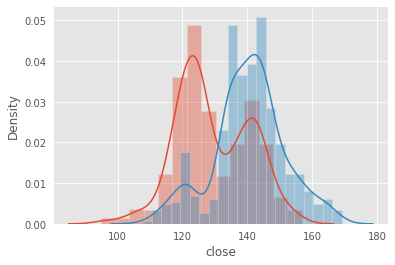

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error

sns_plot = sns.distplot(dataX['close'])
sns_plot2 = sns.distplot(dataY['close'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

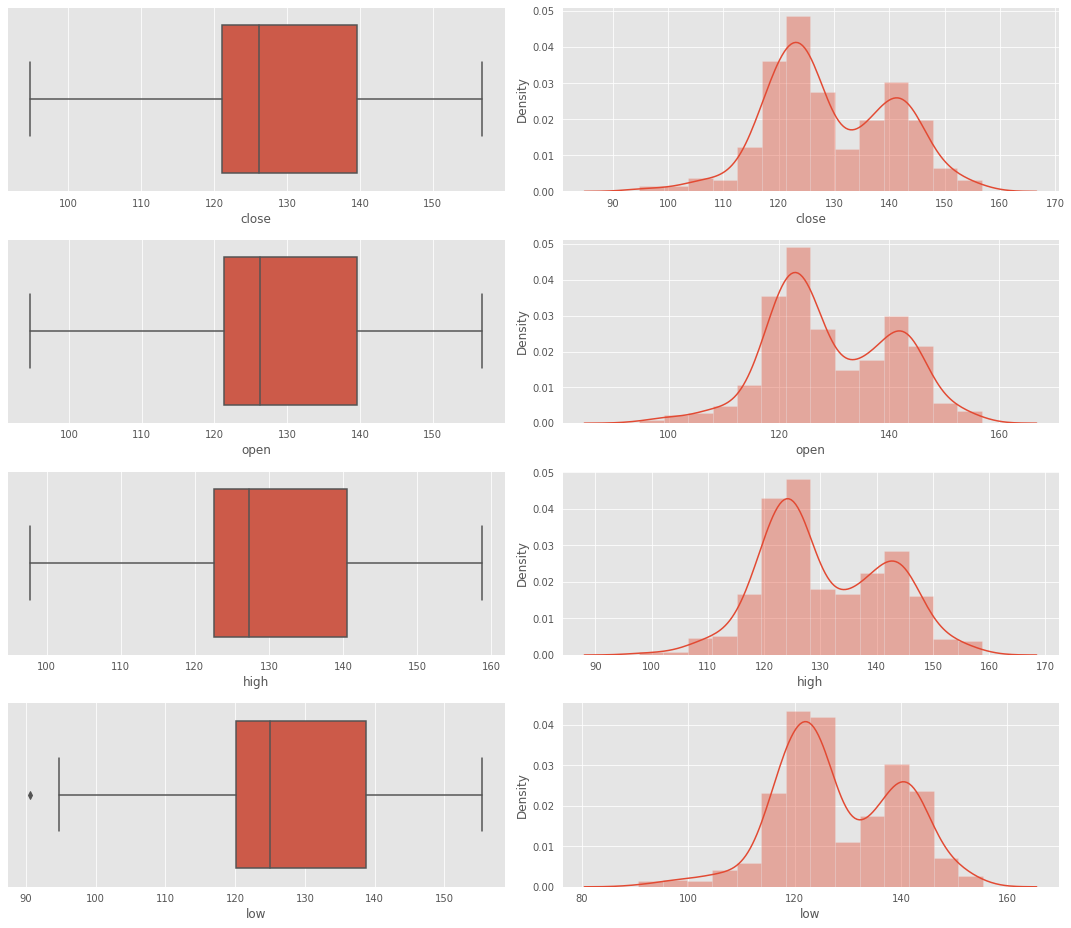

In [67]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataX["close"], ax = ax[0,0])
sns.distplot(dataX['close'], ax = ax[0,1])
sns.boxplot(x= dataX["open"], ax = ax[1,0])
sns.distplot(dataX['open'], ax = ax[1,1])
sns.boxplot(x= dataX["high"], ax = ax[2,0])
sns.distplot(dataX['high'], ax = ax[2,1])
sns.boxplot(x= dataX["low"], ax = ax[3,0])
sns.distplot(dataX['low'], ax = ax[3,1])
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

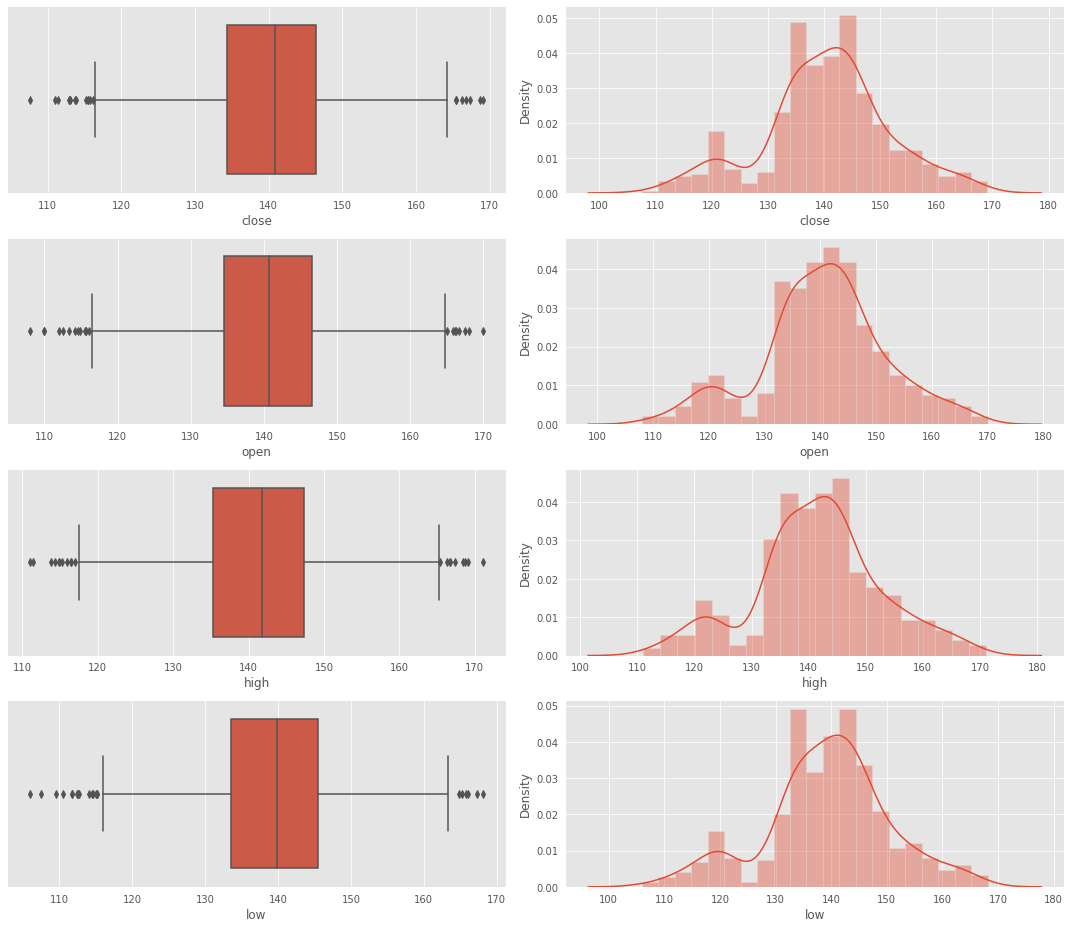

In [68]:
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= dataY["close"], ax = ax[0,0])
sns.distplot(dataY['close'], ax = ax[0,1])
sns.boxplot(x= dataY["open"], ax = ax[1,0])
sns.distplot(dataY['open'], ax = ax[1,1])
sns.boxplot(x= dataY["high"], ax = ax[2,0])
sns.distplot(dataY['high'], ax = ax[2,1])
sns.boxplot(x= dataY["low"], ax = ax[3,0])
sns.distplot(dataY['low'], ax = ax[3,1])
plt.tight_layout()

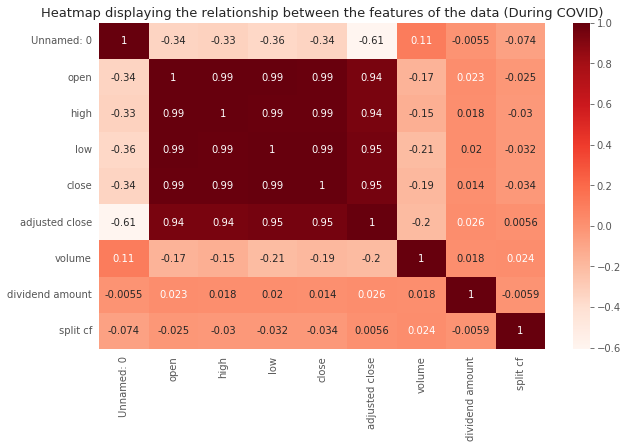

In [74]:
plt.figure(figsize=(10,6))
sns.heatmap(dataX.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (During COVID)',
         fontsize=13)
plt.show()

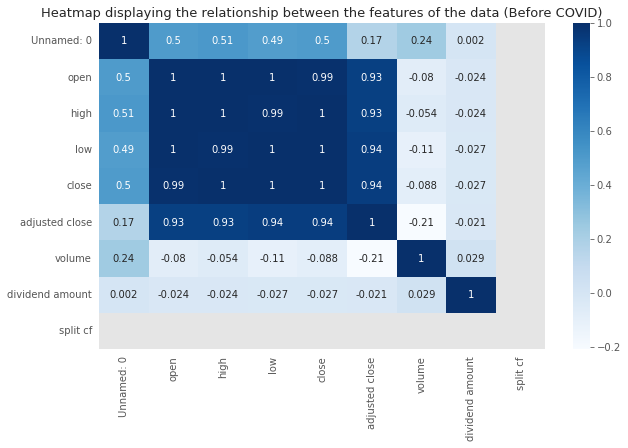

In [75]:
plt.figure(figsize=(10,6))
sns.heatmap(dataY.corr(),cmap=plt.cm.Blues,annot=True)
plt.title('Heatmap displaying the relationship between the features of the data (Before COVID)',
         fontsize=13)
plt.show()